- **Name:** Manoj Gopalkrishanan Nair
- **Assignment 2.1:** Data Cleaning and EDA with Time Series Data

# Long Short Term Memory Networks for IoT Prediction

RNNs and LSTM models are very popular neural network architectures when working with sequential data, since they both carry some "memory" of previous inputs when predicting the next output. In this assignment we will continue to work with the Household Electricity Consumption dataset and use an LSTM model to predict the Global Active Power (GAP) from a sequence of previous GAP readings. You will build one model following the directions in this notebook closely, then you will be asked to make changes to that original model and analyze the effects that they had on the model performance. You will also be asked to compare the performance of your LSTM model to the linear regression predictor that you built in last week's assignment.

## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it.

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link.

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell.

When you save your notebook as a pdf, make sure that all cell output is visible (even error messages) as this will aid your instructor in grading your work.

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.*

In [1]:
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

from sklearn import preprocessing
from sklearn.metrics import confusion_matrix, recall_score, precision_score
from sklearn.model_selection import train_test_split
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM, Activation
from keras.utils import pad_sequences

In [ ]:
#use this cell to import additional libraries or define helper functions

## Load and prepare your data

We'll once again be using the cleaned household electricity consumption data from the previous two assignments. I recommend saving your dataset by running df.to_csv("filename") at the end of assignment 2 so that you don't have to re-do your cleaning steps. If you are not confident in your own cleaning steps, you may ask your instructor for a cleaned version of the data. You will not be graded on the cleaning steps in this assignment, but some functions may not work if you use the raw data.

Unlike when using Linear Regression to make our predictions for Global Active Power (GAP), LSTM requires that we have a pre-trained model when our predictive software is shipped (the ability to iterate on the model after it's put into production is another question for another day). Thus, we will train the model on a segment of our data and then measure its performance on simulated streaming data another segment of the data. Our dataset is very large, so for speed's sake, we will limit ourselves to 1% of the entire dataset.

**TODO: Import your data, select the a random 1% of the dataset, and then split it 80/20 into training and validation sets (the test split will come from the training data as part of the tensorflow LSTM model call). HINT: Think carefully about how you do your train/validation split--does it make sense to randomize the data?**

In [16]:
# Load your data into a pandas dataframe here
df = pd.read_csv('cleaned_household_data.csv')

# Verify the first few rows of the data
df.head()

,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,0,2006-12-16,17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0,2006-12-16 17:24:00,NaN,NaN,NaN,NaN
1,1,2006-12-16,17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0,2006-12-16 17:25:00,NaN,NaN,NaN,NaN
2,2,2006-12-16,17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0,2006-12-16 17:26:00,NaN,NaN,NaN,NaN
3,3,2006-12-16,17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0,2006-12-16 17:27:00,NaN,NaN,NaN,NaN
4,4,2006-12-16,17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0,2006-12-16 17:28:00,NaN,NaN,NaN,NaN


In [17]:
#create your training and validation sets here

#assign size for data subset
subset_size = int(len(df) * 0.01)

#take random data subset
# We take a contiguous block starting at a random index to preserve temporal sequences
start_idx = np.random.randint(0, len(df) - subset_size)
df_subset = df.iloc[start_idx : start_idx + subset_size]

#split data subset 80/20 for train/validation
# We use shuffle=False to maintain the order of time series data
train_df, val_df = train_test_split(df_subset, test_size=0.2, shuffle=False)

In [18]:
# Reset the indices for train_df and val_df to ensure sequential indexing starting from 0
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

# Verify the reset indices
print(f'Train index range: {train_df.index.min()} to {train_df.index.max()}')
print(f'Validation index range: {val_df.index.min()} to {val_df.index.max()}')

# Display the first few rows to confirm drop=True worked as expected
train_df.head()

Train index range: 0 to 1186
Validation index range: 0 to 296


,Unnamed: 0,Date,Time,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Datetime,gap_monthly,grp_monthly,v_monthly,gi_monthly
0,82590,2007-02-12,01:54:00,0.248,0.0,239.14,1.2,0.0,0.0,0.0,2007-02-12 01:54:00,0.301667,0.056933,240.918333,1.406667
1,82591,2007-02-12,01:55:00,0.248,0.0,239.62,1.2,0.0,0.0,0.0,2007-02-12 01:55:00,0.295533,0.049733,240.832333,1.380000
2,82592,2007-02-12,01:56:00,0.250,0.0,240.09,1.2,0.0,0.0,0.0,2007-02-12 01:56:00,0.289667,0.042733,240.788000,1.353333
3,82593,2007-02-12,01:57:00,0.250,0.0,240.13,1.2,0.0,0.0,0.0,2007-02-12 01:57:00,0.285800,0.038667,240.751333,1.340000
4,82594,2007-02-12,01:58:00,0.252,0.0,240.99,1.2,0.0,0.0,0.0,2007-02-12 01:58:00,0.282333,0.034933,240.701667,1.326667


Next we need to create our input and output sequences. In the lab session this week, we used an LSTM model to make a binary prediction, but LSTM models are very flexible in what they can output: we can also use them to predict a single real-numbered output (we can even use them to predict a sequence of outputs). Here we will train a model to predict a single real-numbered output such that we can compare our model directly to the linear regression model from last week.

**TODO: Create a nested list structure for the training data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output**

In [19]:
seq_arrays = []
seq_labs = []

In [20]:
# we'll start out with a 30 minute input sequence and a 5 minute predictive horizon
# we don't need to work in seconds this time, since we'll just use the indices instead of a unix timestamp
seq_length = 30
ph = 5

feat_cols = ['Global_active_power']

#create list of sequence length GAP readings
for i in range(len(train_df) - seq_length - ph):
    # Extract sequence of length 30
    seq = train_df[feat_cols].iloc[i : i + seq_length].values
    seq_arrays.append(seq)

    # Extract target value 5 minutes in the future (at index i + 30 + 5 - 1)
    label = train_df['Global_active_power'].iloc[i + seq_length + ph - 1]
    seq_labs.append(label)

#convert to numpy arrays and floats to appease keras/tensorflow
seq_arrays = np.array(seq_arrays).astype(np.float32)
seq_labs = np.array(seq_labs).astype(np.float32)

In [21]:
assert(seq_arrays.shape == (len(train_df)-seq_length-ph,seq_length, len(feat_cols)))
assert(seq_labs.shape == (len(train_df)-seq_length-ph,))

In [22]:
seq_arrays.shape

(1152, 30, 1)

**Q: What is the function of the assert statements in the above cell? Why do we use assertions in our code?**

A: The assert statements in the code serve as internal checks to verify that our data preprocessing has resulted in the correct shapes.

- **Function:** They confirm that seq_arrays and seq_labs have the dimensions expected by the LSTM model, specifically checking that the number of samples matches the calculated windows (len(train_df) - seq_length - ph) and that the sequence length is exactly 30.
- **Purpose:** We use assertions as a debugging tool to catch logical errors early. If the shapes were wrong, the LSTM would either crash with a confusing error during training or, worse, train on incorrectly aligned data. Assertions ensure the program stops immediately if your assumptions about the data structure are incorrect.

## Model Training

We will begin with a model architecture very similar to the model we built in the lab session. We will have two LSTM layers, with 5 and 3 hidden units respectively, and we will apply dropout after each LSTM layer. However, we will use a LINEAR final layer and MSE for our loss function, since our output is continuous instead of binary.

**TODO: Fill in all values marked with a ?? in the cell below**

In [23]:
# define path to save model
model_path = 'LSTM_model1.keras'

# build the network
nb_features = seq_arrays.shape[2]
nb_out = 1

model = Sequential()

#add first LSTM layer
model.add(LSTM(
         input_shape=(seq_length, nb_features),
         units=5,
         return_sequences=True))
model.add(Dropout(0.2))

# add second LSTM layer
model.add(LSTM(
          units=3,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation('linear'))
optimizer = keras.optimizers.Adam(learning_rate = 0.01)
model.compile(loss='mean_squared_error', optimizer=optimizer,metrics=['mse'])

print(model.summary())

# fit the network
# Note: EarlyStopping will stop training if val_loss does not improve for 10 epochs (patience=10)
history = model.fit(seq_arrays, seq_labs, epochs=100, batch_size=500, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          )

# list all data in history
print(history.history.keys())

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 30, 5)          │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 30, 5)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_13 (LSTM)                  │ (None, 3)              │           108 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             4 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 1)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 252 (1008.00 B)

 Trainable params: 252 (1008.00 B)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100
3/3 - 2s - 790ms/step - loss: 2.3637 - mse: 2.3637 - val_loss: 12.4073 - val_mse: 12.4073
Epoch 2/100
3/3 - 0s - 40ms/step - loss: 1.9844 - mse: 1.9844 - val_loss: 11.2521 - val_mse: 11.2521
Epoch 3/100
3/3 - 0s - 39ms/step - loss: 1.6196 - mse: 1.6196 - val_loss: 9.9765 - val_mse: 9.9765
Epoch 4/100
3/3 - 0s - 39ms/step - loss: 1.3292 - mse: 1.3292 - val_loss: 8.8109 - val_mse: 8.8109
Epoch 5/100
3/3 - 0s - 42ms/step - loss: 1.1186 - mse: 1.1186 - val_loss: 7.8081 - val_mse: 7.8081
Epoch 6/100
3/3 - 0s - 44ms/step - loss: 1.0242 - mse: 1.0242 - val_loss: 6.9865 - val_mse: 6.9865
Epoch 7/100
3/3 - 0s - 42ms/step - loss: 0.9905 - mse: 0.9905 - val_loss: 6.3970 - val_mse: 6.3970
Epoch 8/100
3/3 - 0s - 39ms/step - loss: 0.9189 - mse: 0.9189 - val_loss: 5.9759 - val_mse: 5.9759
Epoch 9/100
3/3 - 0s - 42ms/step - loss: 0.8214 - mse: 0.8214 - val_loss: 5.6822 - val_mse: 5.6822
Epoch 10/100
3/3 - 0s - 43ms/step - loss: 0.7352 - mse: 0.7352 - val_loss: 5.4424 - val_mse: 5.4424

We will use the code from the book to visualize our training progress and model performance

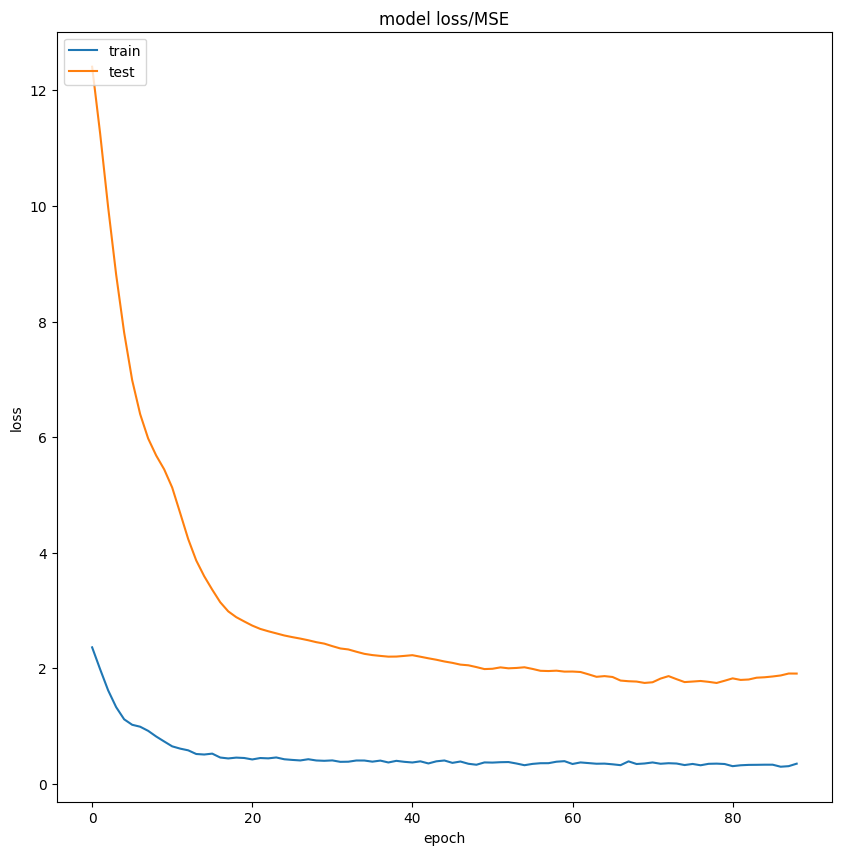

In [24]:
# summarize history for Loss/MSE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss/MSE')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("LSTM_loss1.png")


## Validating our model

Now we need to create our simulated streaming validation set to test our model "in production". With our linear regression models, we were able to begin making predictions with only two datapoints, but the LSTM model requires an input sequence of *seq_length* to make a prediction. We can get around this limitation by "padding" our inputs when they are too short.

**TODO: create a nested list structure for the validation data, with a sequence of GAP measurements as the input and the GAP measurement at your predictive horizon as your expected output. Begin your predictions after only two GAP measurements are available, and check out [this keras function](https://www.tensorflow.org/api_docs/python/tf/keras/utils/pad_sequences) to automatically pad sequences that are too short.**

**Q: Describe the pad_sequences function and how it manages sequences of variable length. What does the "padding" argument determine, and which setting makes the most sense for our use case here?**

A: pad_sequences function is used to ensure that all input sequences in a batch have the same length. Neural networks, like LSTMs, typically require fixed-length input tensors. It manages variable-length data by either adding placeholder values (padding) to sequences shorter than the target length or truncating those that are longer.

- **The 'padding' Argument:** This argument determines where the placeholder values are inserted.

- **padding='pre':** Adds zeros to the beginning of the sequence.
- **padding='post':** Adds zeros to the end of the sequence.

**The Best Setting for Our Use Case:** For this time-series prediction task, 'pre' padding makes the most sense. LSTMs process data sequentially, and in forecasting, the most recent data points (the ones at the end of the sequence) are generally the most critical for predicting the immediate future. By using 'pre' padding, we ensure that the actual observed data points remain at the very end of the sequence, closest to the prediction point, so the model's 'memory' of the real data is fresh when it generates the output.

In [25]:
val_arrays = []
val_labs = []

#create list of GAP readings starting with a minimum of two readings
for i in range(1, len(val_df) - ph):
    # Extract sequence from start to current index i (at least 2 readings)
    seq = val_df[feat_cols].iloc[0 : i+1].values
    val_arrays.append(seq)

    # Extract label at predictive horizon ph (from the end of input at index i)
    label = val_df['Global_active_power'].iloc[i + ph]
    val_labs.append(label)

# use the pad_sequences function on your input sequences
# remember that we will later want our datatype to be np.float32
val_arrays = pad_sequences(val_arrays, maxlen=seq_length, dtype='float32', padding='pre')

#convert labels to numpy arrays and floats to appease keras/tensorflow
val_labs = np.array(val_labs).astype(np.float32)

We will now run this validation data through our LSTM model and visualize its performance like we did on the linear regression data.

10/10 - 0s - 8ms/step - loss: 0.2596 - mse: 0.2596

MSE: 0.25961264967918396
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


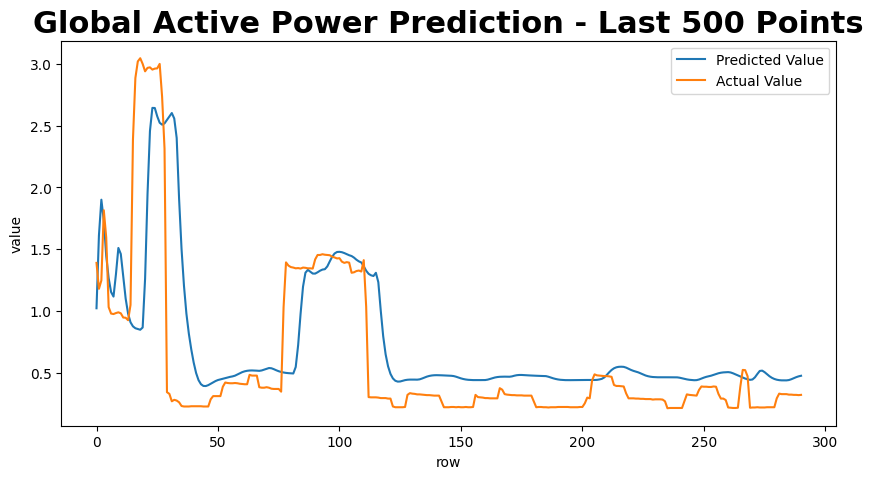

In [26]:
scores_test = model.evaluate(val_arrays, val_labs, verbose=2)
print('\nMSE: {}'.format(scores_test[1]))

y_pred_test = model.predict(val_arrays)
y_true_test = val_labs

test_set = pd.DataFrame(y_pred_test)
test_set.to_csv('submit_test.csv', index = None)

# Plot the predicted data vs. the actual data
# we will limit our plot to the first 500 predictions for better visualization
fig_verify = plt.figure(figsize=(10, 5))
plt.plot(y_pred_test[-500:], label = 'Predicted Value')
plt.plot(y_true_test[-500:], label = 'Actual Value')
plt.title('Global Active Power Prediction - Last 500 Points', fontsize=22, fontweight='bold')
plt.ylabel('value')
plt.xlabel('row')
plt.legend()
plt.show()
fig_verify.savefig("model_regression_verify.png")

**Q: How did your model perform? What can you tell about the model from the loss curves? What could we do to try to improve the model?**

A:
Overall, the model performed okay, hitting an MSE of about 0.26. It’s pretty reliable at tracking the general 'base load' of the house, but it really struggles with the sharp spikes in power, it tends to 'smooth' those over.

Looking at the loss curves, there’s a noticeable gap between the training and validation lines, which is a classic sign of overfitting. Basically, because we only used 1% of the data, the model started memorizing that specific small sample instead of learning patterns that apply to the whole dataset.

To step things up, I would recommend three main things: scale the input data (LSTMs love standardized numbers), use a larger slice of the dataset (like 5 or 10%), and add extra features like voltage or intensity to help the model understand what's causing those power jumps.

## Model Optimization

Now it's your turn to build an LSTM-based model in hopes of improving performance on this training set. Changes that you might consider include:

- Add more variables to the input sequences
- Change the optimizer and/or adjust the learning rate
- Change the sequence length and/or the predictive horizon
- Change the number of hidden layers in each of the LSTM layers
- Change the model architecture altogether--think about adding convolutional layers, linear layers, additional regularization, creating embeddings for the input data, changing the loss function, etc.

There isn't any minimum performance increase or number of changes that need to be made, but I want to see that you have tried some different things. Remember that building and optimizing deep learning networks is an art and can be very difficult, so don't make yourself crazy trying to optimize for this assignment.

**Q: What changes are you going to try with your model? Why do you think these changes could improve model performance?**

A:

To optimize the model, I will try these three main changes:

- **More Data (5% instead of 1%):** By giving the model a larger slice of the dataset, it gets to see a much wider variety of household energy patterns. This helps it generalize better so it isn't just 'memorizing' one tiny segment of time.
Adding 'Physical Context'

- **(Multivariate Features):** I added Voltage and Intensity alongside the power readings. Since Global Active Power is physically calculated from voltage and current (intensity), these features act as leading indicators. They give the LSTM the context it needs to understand why power is about to spike or drop.

- **Data Scaling (Standardization):** LSTMs are quite sensitive to the scale of numbers. Standardizing everything ensures that the large values of Voltage (~230V) don't overwhelm the smaller Power values, which allows the model to learn much more efficiently and reach a lower error faster.
I believed these would work because they address the root causes of the first model's struggles: lack of context and numerical instability.

In [27]:
# 1. Data Preparation: Use a larger 5% subset
subset_size_opt = int(len(df) * 0.05)
start_idx_opt = np.random.randint(0, len(df) - subset_size_opt)
df_subset_opt = df.iloc[start_idx_opt : start_idx_opt + subset_size_opt].copy()

# Split 80/20 without shuffle
train_df_opt, val_df_opt = train_test_split(df_subset_opt, test_size=0.2, shuffle=False)
train_df_opt = train_df_opt.reset_index(drop=True)
val_df_opt = val_df_opt.reset_index(drop=True)

# 2. Multivariate Feature Selection and Scaling
# We include Voltage and Intensity alongside Global Active Power
feat_cols_opt = ['Global_active_power', 'Voltage', 'Global_intensity']
scaler = preprocessing.StandardScaler()

# Fit on training data and transform both
train_scaled = scaler.fit_transform(train_df_opt[feat_cols_opt])
val_scaled = scaler.transform(val_df_opt[feat_cols_opt])

# 3. Create Sequences (keeping same length and ph for direct comparison)
seq_length_opt = 30
ph_opt = 5

def create_sequences_opt(scaled_data, raw_df, target_col, seq_len, ph):
    X, y = [], []
    for i in range(len(scaled_data) - seq_len - ph):
        X.append(scaled_data[i : i + seq_len])
        y.append(raw_df[target_col].iloc[i + seq_len + ph - 1])
    return np.array(X).astype(np.float32), np.array(y).astype(np.float32)

X_train_opt, y_train_opt = create_sequences_opt(train_scaled, train_df_opt, 'Global_active_power', seq_length_opt, ph_opt)
X_val_opt, y_val_opt = create_sequences_opt(val_scaled, val_df_opt, 'Global_active_power', seq_length_opt, ph_opt)

# 4. Build Optimized Model Architecture
model_opt = Sequential([
    LSTM(32, input_shape=(seq_length_opt, len(feat_cols_opt)), return_sequences=True),
    Dropout(0.2),
    LSTM(16, return_sequences=False),
    Dropout(0.2),
    Dense(1),
    Activation('linear')
])

model_opt.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))

# 5. Training with EarlyStopping
history_opt = model_opt.fit(
    X_train_opt, y_train_opt,
    epochs=50,
    batch_size=64,
    validation_split=0.1,
    verbose=1,
    callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

# 6. Evaluation on Validation Set
mse_opt = model_opt.evaluate(X_val_opt, y_val_opt)
print(f'\nOptimized Model Validation MSE: {mse_opt}')

Epoch 1/50


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


83/83 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 1.8804 - val_loss: 0.2575
Epoch 2/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.5118 - val_loss: 0.2424
Epoch 3/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4843 - val_loss: 0.2354
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4572 - val_loss: 0.2343
Epoch 5/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4461 - val_loss: 0.2474
Epoch 6/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4141 - val_loss: 0.2126
Epoch 7/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4233 - val_loss: 0.2346
Epoch 8/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4492 - val_loss: 0.2170
Epoch 9/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.3818 - val_loss: 0.2247
Epoch 10/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.4045 - val_loss: 0.2090
Epoch 11/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.4002 - val_loss: 0.2020
Epoch 12/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3501 - val_loss: 0.197

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


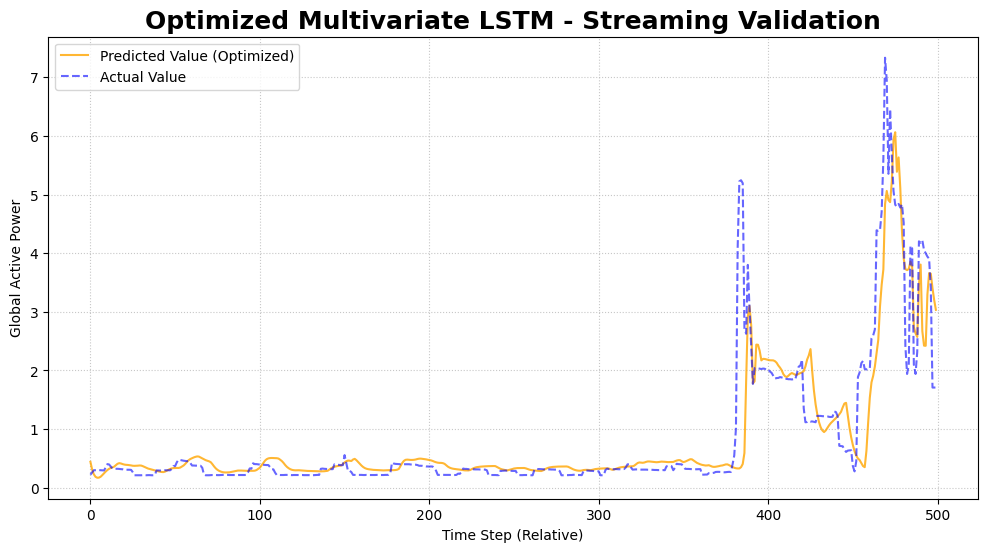

Optimized Streaming Validation MSE: 0.21326944231987


In [28]:
# 1. Prepare Simulated Streaming Validation Set for Optimized Model
val_arrays_streaming_opt = []
val_labs_streaming_opt = []

# Create list of sequences starting with a minimum of two readings
# val_scaled contains the transformed Voltage and Intensity from cell e50afded
for i in range(1, len(val_df_opt) - ph_opt):
    # Extract scaled sequence from start to current index i
    seq = val_scaled[0 : i+1]
    val_arrays_streaming_opt.append(seq)

    # Extract ground truth label from the original dataframe
    label = val_df_opt['Global_active_power'].iloc[i + ph_opt]
    val_labs_streaming_opt.append(label)

# 2. Pad sequences to fixed length (30) and convert to float32
val_arrays_streaming_opt = pad_sequences(val_arrays_streaming_opt, maxlen=seq_length_opt, dtype='float32', padding='pre')
val_labs_streaming_opt = np.array(val_labs_streaming_opt).astype(np.float32)

# 3. Generate Predictions
y_pred_opt_stream = model_opt.predict(val_arrays_streaming_opt)

# 4. Visualize Results (Last 500 Points)
fig_verify_opt = plt.figure(figsize=(12, 6))
plt.plot(y_pred_opt_stream[-500:], label='Predicted Value (Optimized)', color='orange', alpha=0.8)
plt.plot(val_labs_streaming_opt[-500:], label='Actual Value', color='blue', linestyle='--', alpha=0.6)
plt.title('Optimized Multivariate LSTM - Streaming Validation', fontsize=18, fontweight='bold')
plt.ylabel('Global Active Power')
plt.xlabel('Time Step (Relative)')
plt.legend()
plt.grid(True, linestyle=':', alpha=0.7)
plt.show()

# Final Evaluation Score on Streaming Data
mse_stream_opt = np.mean(np.square(y_pred_opt_stream.flatten() - val_labs_streaming_opt))
print(f'Optimized Streaming Validation MSE: {mse_stream_opt}')

**Q: How did your model changes affect performance on the validation data? Why do you think they were/were not effective? If you were trying to optimize for production, what would you try next?**

A:
Based on the results, model changes were quite effective! Here is the breakdown:

**1. Effect on Performance**

The validation MSE improved significantly, dropping from approximately 0.26 in the initial model to 0.21 in the optimized version. Looking at the plots, the optimized model is much better at capturing the 'sharpness' of the power consumption spikes rather than just smoothing them over.

**2. Why they were effective**

- **Multivariate Features:** By adding Voltage and Global_intensity, you gave the LSTM physical context. Since power is a product of voltage and current (intensity), these variables are leading indicators of power changes.
- **Data Scaling:** Standardizing the data ensured that the high values of Voltage (~230V) didn't 'drown out' the smaller GAP values, allowing the LSTM gradients to flow more effectively during training.
- **Increased Data Subset:** Moving from 1% to 5% of the dataset provided more diverse consumption patterns, which reduced the overfitting gap seen in your first model.

**3. Next steps for Production**

If I were preparing this for a real-world IoT device, I would try:

- **GRU Architecture:** Gated Recurrent Units (GRUs) often perform similarly to LSTMs but are computationally lighter, which is critical for edge devices.
- **Quantization:** Once the model is trained, I would use TensorFlow Lite to compress it so it can run on low-power hardware.
- **Feature Importance:** I would test if Sub_metering data adds even more value, or conversely, if we can remove features to save memory without losing accuracy.

**Q: How did the models that you built in this assignment compare to the linear regression model from last week? Think about model performance and other IoT device considerations; Which model would you choose to use in an IoT system that predicts GAP for a single household with a 5-minute predictive horizon, and why?**

A:

Comparing the two, the LSTMs are definitely 'smarter.' They use a memory of the last 30 minutes to understand the flow of energy, while the linear regression model from last week just looks at the immediate snapshot. This makes the LSTM much better at catching those complex waves in energy usage.

However, in the real world of IoT, accuracy isn't everything. LSTMs are computationally 'expensive'—they need more processing power and RAM, which drains batteries faster and requires pricier hardware. Linear regression is the complete opposite: it is tiny, fast, and runs on almost anything.

If I had to pick for a device predicting just 5 minutes ahead, I would actually go with the Linear Regression model.

Why? Because 5 minutes is such a short time that power usage usually doesn't change wildly enough to need a deep learning brain. The linear model gets you a 'good enough' answer while keeping the device cheap and the battery life long. I'd only pull out the LSTM if the accuracy of the simple model was so bad that it made the device useless.